## Importo las librerias necesarias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import adi
from scipy.fftpack import fft, fftfreq
from scipy.signal import butter, lfilter
from scipy.signal import kaiserord, firwin, freqz
from scipy import signal
%matplotlib notebook

## Señales

In [46]:
duracion = 1 # segundos
fs = 2.048e6   # Frecuencia de muestreo
n = np.arange(fs*duracion)

# Señal A
amplitud_A = 1
f_A = 1000
#signal_A = (amplitud_A * np.sin(2*np.pi*(f_A/fs)*n)).astype(np.float32)
signal_A = (amplitud_A * np.exp(1j*2*np.pi*(f_A/fs)*n))*2**14
             
# Señal B
amplitud_B = 1
f_B = 1500
signal_B = (amplitud_B * np.exp(1j*2*np.pi*(f_B/fs)*n))*2**14
             
# Señal C
amplitud_C = 1
f_C = 3000
signal_C = (amplitud_C * np.exp(1j*2*np.pi*(f_C/fs)*n))*2**14



## Sumo las tres señales

In [47]:
signal_out = signal_A + signal_B + signal_C

## Modulo las tres señales

## Grafico en funcion del tiempo

<IPython.core.display.Javascript object>


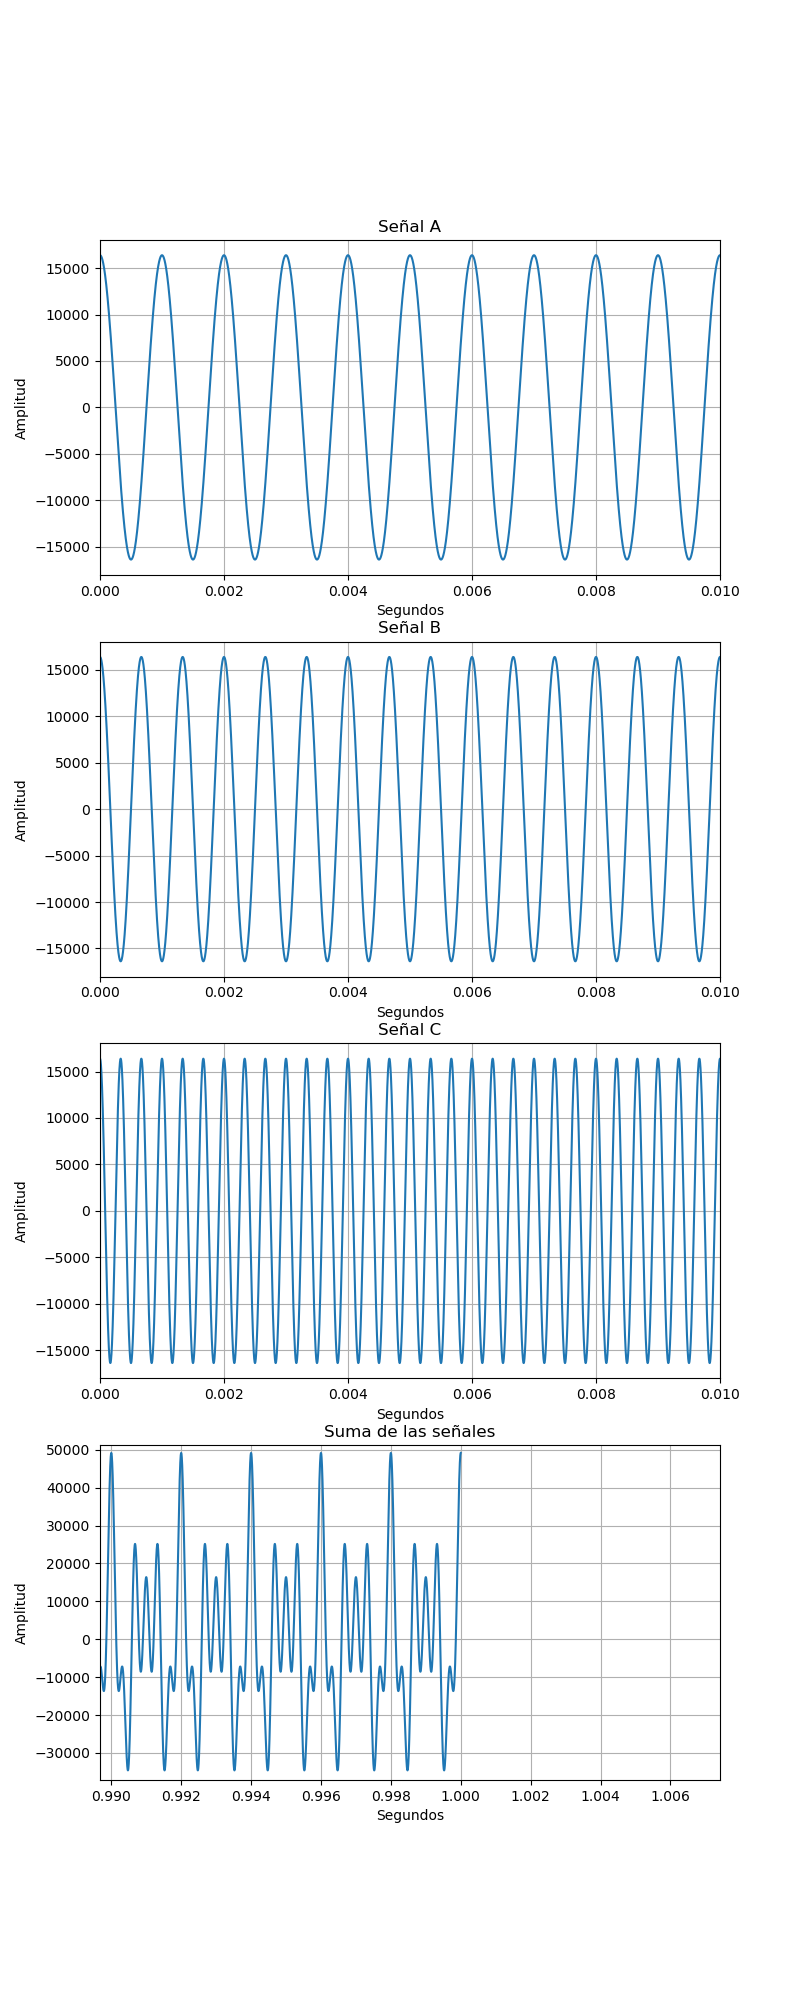

C:\Users\Mayco\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Mayco\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Mayco\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Mayco\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [59]:
plt.figure(figsize=(8,20))
plt.subplot(411)
plt.plot(n/fs, signal_A)
plt.title("Señal A")
plt.xlabel("Segundos")
plt.ylabel("Amplitud")
plt.grid()
plt.xlim(0,0.01)
plt.subplot(412)
plt.plot(n/fs, signal_B)
plt.title("Señal B")
plt.xlabel("Segundos")
plt.ylabel("Amplitud")
plt.grid()
plt.xlim(0,0.01)
plt.subplot(413)
plt.plot(n/fs, signal_C)
plt.title("Señal C")
plt.xlabel("Segundos")
plt.ylabel("Amplitud")
plt.grid()
plt.xlim(0,0.01)
plt.subplot(414)
plt.plot(n/fs, signal_out)
plt.title("Suma de las señales")
plt.xlabel("Segundos")
plt.ylabel("Amplitud")
plt.grid()
#plt.xlim(0,0.01)
plt.show()


## Grafico en frecuencia

<IPython.core.display.Javascript object>


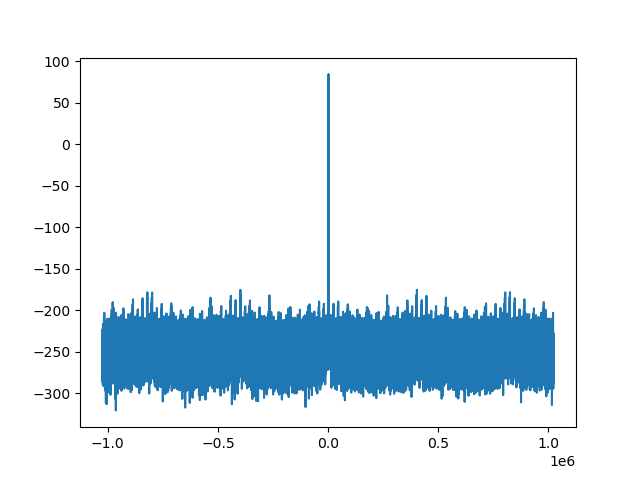

In [49]:
plt.figure()
N = signal_out.shape[0]
Y = fft(signal_out)/N
frq = fftfreq(N, 1/fs)
plt.plot(frq, 20*np.log10(abs(Y)))
plt.show()

## Configuro la Pluto y transmito la señal

In [50]:
sdr = adi.Pluto()

sdr.rx_lo = 1000000000 # [Hz]
sdr.rx_buffer_size = len(n)

sdr.tx_destroy_buffer()
sdr.tx_lo = 1000000000 # [Hz]
sdr.tx_cyclic_buffer = True
sdr.tx_hardwaregain_chan0 = -10
sdr.gain_control_mode_cahn0 = "slow_attack"
sdr.sample_rate = fs # [Hz]

fs_pluto = int(sdr.sample_rate)
print('fs =',fs_pluto)

# Send data
sdr.tx(signal_out)

fs = 2047999


In [36]:
#del(sdr)

## Recibo la señal

(2048000,)


<IPython.core.display.Javascript object>


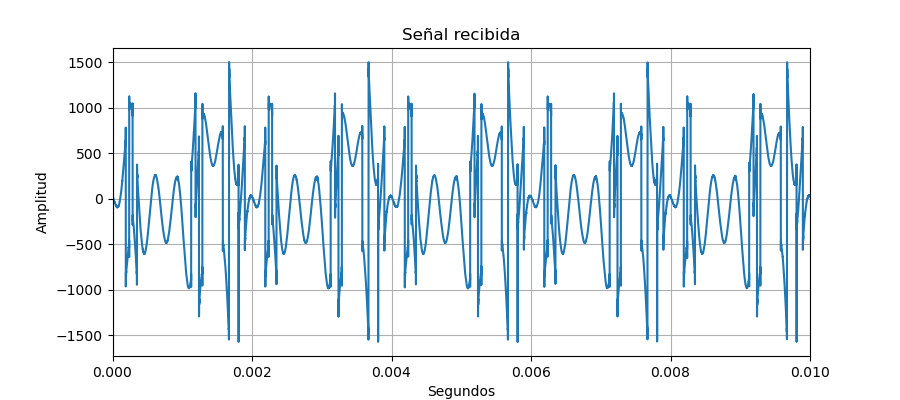

In [51]:
signal_in = sdr.rx()
print(signal_in.shape)
plt.figure(figsize=(9,4))
plt.plot(n/fs, np.real(signal_in))
plt.title("Señal recibida")
plt.xlabel("Segundos")
plt.ylabel("Amplitud")
plt.xlim(0,0.01)
plt.grid()

<IPython.core.display.Javascript object>


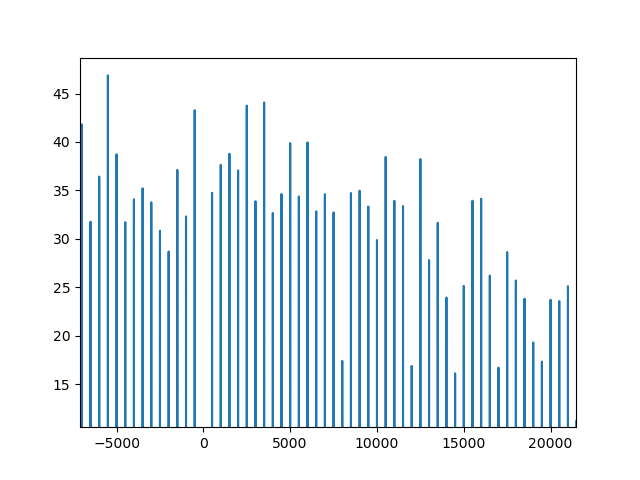

In [52]:
plt.figure()
n_3 = signal_in.shape[0]
Y = fft(signal_in)/n_3 # Normalizada
frq = fftfreq(n_3, 1/fs_pluto) # Recuperamos las frecuencias
plt.plot(frq, 20*np.log10(abs(Y))) # Representamos la parte imaginaria
plt.show()

## Filtro pasa banda, entre 800Hz y 3200Hz

In [61]:
nyq = fs/2
low = 800 / nyq
high = 3200 / nyq
transition_width = 250/ nyq
atenuacion = 70
numtaps, beta = kaiserord(atenuacion, transition_width)
taps = signal.firwin(numtaps, [low, high], width=transition_width, window=('kaiser', beta), pass_zero=False)
signal_in_filter_3tonos = lfilter(taps, 1.0, signal_in)

## Filtro pasa banda, entre 2800Hz y 3200Hz

In [53]:
nyq = fs/2
low = 2800 / nyq
high = 3200 / nyq
transition_width = 250/ nyq
atenuacion = 70
numtaps, beta = kaiserord(atenuacion, transition_width)

print(numtaps)
print(beta)

35407
6.75526


In [54]:
taps = signal.firwin(numtaps, [low, high], width=transition_width, window=('kaiser', beta), pass_zero=False)

In [55]:
signal_in_filter = lfilter(taps, 1.0, signal_in)

## Grafico en funcion del tiempo

<IPython.core.display.Javascript object>


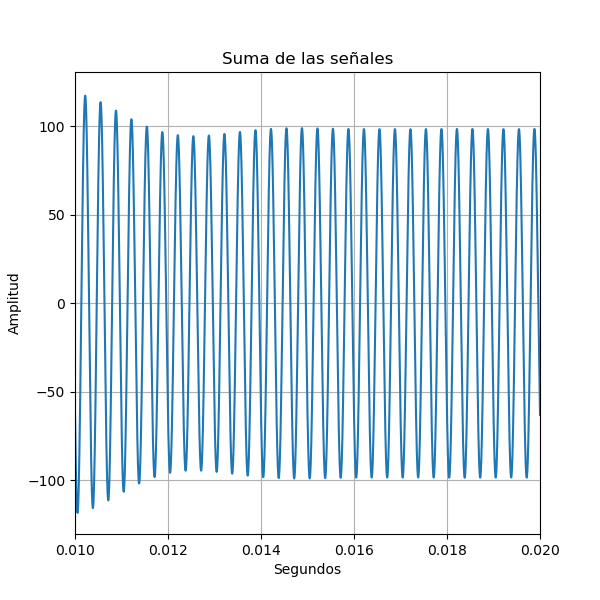

C:\Users\Mayco\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [67]:
plt.figure(figsize=(6,6))
#plt.subplot(211)
#plt.plot(n/fs, signal_in_filter_3tonos)
#plt.title("Suma de las señales")
#plt.xlabel("Segundos")
#plt.ylabel("Amplitud")
#plt.grid()
#plt.xlim(0.01,0.02)
#plt.subplot(212)
plt.plot(n/fs, signal_in_filter)
plt.title("Suma de las señales")
plt.xlabel("Segundos")
plt.ylabel("Amplitud")
plt.grid()
plt.xlim(0.01,0.02)
plt.show()


## Grafico en frecuencia

<IPython.core.display.Javascript object>


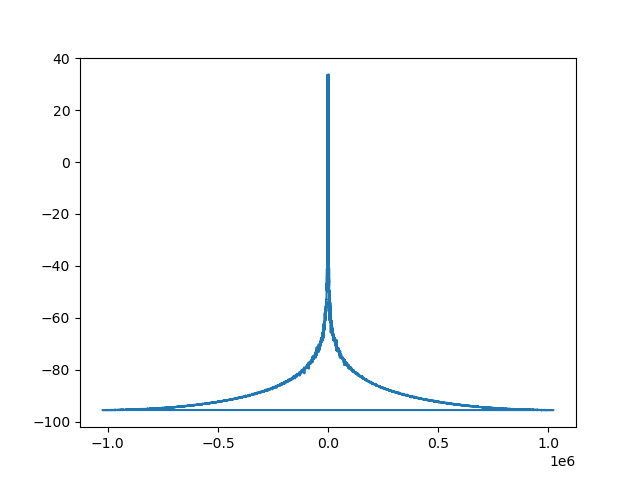

In [57]:
plt.figure()
n_2 = signal_in_filter.shape[0]
Y = fft(signal_in_filter)/n_2 # Normalizada
frq = fftfreq(n_2, 1/fs) # Recuperamos las frecuencias
plt.plot(frq, 20*np.log10(abs(Y))) # Representamos la parte imaginaria
plt.show()